In [25]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd

import scipy
import pywt
import mne

import sys
from tqdm import tqdm


sys.path.append('../utils')
from ERP_utils import *
from update_sub_lists import *
from wavelet_utils import *
import glob
import os

In [26]:
task = 'listen'
erp_window = '_n05to05'
freq_high = 30

###### CHOOSE SUBJECTS
subjects_to_process = find_existing_subjects(task = task, period = 'pre',erp_window=erp_window,freq_high=freq_high) #subs that exist in pre should exist in post
#subjects_to_process = ['01']

##### CHOOSE CHANNELS
#ch_to_process = 'all'
ch_to_process = ch_index(['Cz'])



wavelet_params = {
    'fs' :128 , # example sampling frequency in Hz
    'centerfreq' : 5 ,
    'bandwidth': 1.5,
    'level': 10,
    'scale_values':[6, 150, 40]
}

epochs_dir = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_{task}/{task}_epochs_data{erp_window}_{freq_high}Hz'
wavelet_dir = f"./wavelets_mat_{task}_{erp_window}_{freq_high}Hz"

print('processing subjects:', subjects_to_process)
print('processing channels:', ch_to_process)

mne.set_log_level('CRITICAL')

processing subjects: ['01', '01', '02', '02', '03', '03', '04', '04', '05', '05', '06', '06', '07', '07', '08', '08', '09', '09', '10', '10', '11', '11', '12', '12', '13', '13', '14', '14', '15', '15', '16', '16', '17', '17', '18', '18', '19', '19', '20', '20', '21', '21']
processing channels: [47]


## Batch processing wavelets

In [27]:
def wavelet_batch(subjects_to_process, channels, ep_dir, output_dir, wavelet_params, ave = False, overwrite = False, erp_begin = -0.5, erp_end = 0.5):

    """
    wavelet transforms epochs trial by trial for each subject

    
    subjects_to_process: list of subjects
    channels: 'all' or a list of channels. If not all, will only save the wavelet transformed channels and others are discarded
    ep_dir: directory where epochs are saved
    output_dir: dir to save wavelet data
    wavelet_params: dict with wavelet parameters. Example:
        wavelet_params = {
                'fs' :128 , # example sampling frequency in Hz
                'centerfreq' : 5 ,
                'bandwidth': 1.5,
                'level': 10,
                'scale_values':[6, 150, 40]
            }

    ave: whether to average spectrograms all the trials before saving (TO IMPLEMENT)

     ----
    saves wavelet transforms to .mat files
    'wavelet': wavelet data of dim n_trials x n_channels x spect_freqs x spect_times
    """
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)

    times = create_erp_times(erp_begin, erp_end, 128)

    #check file type
    for fif_name in sorted(os.listdir(ep_dir)):
        if not fif_name.endswith(".fif"):
            print('skipping file, not epochs:', fif_name)
            continue

    #identify subject
        subject_id = fif_name.split("_")[-1].split(".")[0]
        if subject_id not in subjects_to_process:
           # print(f'subject {subject_id} not in subjects to process. skipping...')
            continue
        
        mat_name = fif_name.split(".")[0].replace("epochs", "wavelet")
        mat_path = os.path.join(output_dir, f"{mat_name}.mat")

        if not os.path.exists(mat_path) or overwrite: #skip if the file already exists
            print('processing', fif_name)
            
            #get data to loop over
            epochs = mne.read_epochs(os.path.join(ep_dir, fif_name))

            
            epochs_data = epochs.get_data()

            wavelet_data = []
            #for trial in range(10):
            for trial in tqdm(range(epochs_data.shape[0])):
                
                #initiate storage matrix
                n_freqs = wavelet_params['scale_values'][2]
                n_times = times.shape[0]
                if isinstance(channels, str) and channels == 'all':
                    trial_wavelet = np.zeros((64, n_freqs, n_times))
                    ch_towav = np.arange(64) 
                else:
                    trial_wavelet = np.zeros((len(channels), n_freqs, n_times)) 
                    ch_towav = channels

                for j, ch in enumerate(ch_towav):
                    trial_data = epochs_data[trial, ch, :]

                    cwtmatr, freqs, wavelet = morwav_trans(trial_data, 
                                                    centerfreq=wavelet_params['centerfreq'], 
                                                    bandwidth=wavelet_params['bandwidth'], 
                                                    scale_values=wavelet_params['scale_values'])

                    cwtmatr_abs = np.abs(cwtmatr)
                    trial_wavelet[j, :,:] = cwtmatr_abs

                wavelet_data.append(trial_wavelet)

            #save subject data to mat file
            wavelet_data = np.array(wavelet_data)
            wavelet_tosave = {
                'wavelet_transform':wavelet_data
            }

            savemat(mat_path, wavelet_tosave)
    
    #processing record for wavelet
    
    wavelet_record = {
        'freqs': freqs,
        'wavelet': wavelet,
        'subjects': subjects_to_process,
        'centerfreq': wavelet_params['centerfreq'],
        'bandwidth': wavelet_params['bandwidth'],
        'scale_values': wavelet_params['scale_values'],
        'times': times, 
        'channels': channels
    }
    savemat(os.path.join(output_dir, f'wavelet_record.mat'), wavelet_record)


In [28]:

wavelet_batch(subjects_to_process, ch_to_process, epochs_dir, wavelet_dir, wavelet_params, overwrite=True)

processing listen_epochs_post_01.fif


  0%|          | 0/328 [00:00<?, ?it/s]

100%|██████████| 328/328 [00:00<00:00, 380.12it/s]


processing listen_epochs_post_02.fif


100%|██████████| 328/328 [00:00<00:00, 373.99it/s]


processing listen_epochs_post_03.fif


100%|██████████| 268/268 [00:00<00:00, 381.83it/s]


processing listen_epochs_post_04.fif


100%|██████████| 328/328 [00:00<00:00, 384.30it/s]


processing listen_epochs_post_05.fif


100%|██████████| 328/328 [00:00<00:00, 382.07it/s]


processing listen_epochs_post_06.fif


100%|██████████| 328/328 [00:00<00:00, 380.42it/s]


processing listen_epochs_post_07.fif


100%|██████████| 328/328 [00:00<00:00, 381.12it/s]


processing listen_epochs_post_08.fif


100%|██████████| 328/328 [00:00<00:00, 371.71it/s]


processing listen_epochs_post_09.fif


100%|██████████| 328/328 [00:00<00:00, 383.92it/s]


processing listen_epochs_post_10.fif


100%|██████████| 322/322 [00:00<00:00, 379.72it/s]


processing listen_epochs_post_11.fif


100%|██████████| 328/328 [00:00<00:00, 379.10it/s]


processing listen_epochs_post_12.fif


100%|██████████| 328/328 [00:00<00:00, 380.34it/s]


processing listen_epochs_post_13.fif


100%|██████████| 328/328 [00:00<00:00, 376.44it/s]


processing listen_epochs_post_14.fif


100%|██████████| 328/328 [00:00<00:00, 381.73it/s]


processing listen_epochs_post_15.fif


100%|██████████| 314/314 [00:00<00:00, 384.03it/s]


processing listen_epochs_post_16.fif


100%|██████████| 328/328 [00:00<00:00, 381.74it/s]


processing listen_epochs_post_17.fif


100%|██████████| 328/328 [00:00<00:00, 383.89it/s]


processing listen_epochs_post_18.fif


100%|██████████| 328/328 [00:00<00:00, 381.79it/s]


processing listen_epochs_post_19.fif


100%|██████████| 328/328 [00:00<00:00, 374.62it/s]


processing listen_epochs_post_20.fif


100%|██████████| 328/328 [00:00<00:00, 381.94it/s]


processing listen_epochs_post_21.fif


100%|██████████| 328/328 [00:00<00:00, 382.73it/s]


processing listen_epochs_pre_01.fif


100%|██████████| 328/328 [00:00<00:00, 381.83it/s]


processing listen_epochs_pre_02.fif


100%|██████████| 328/328 [00:00<00:00, 383.98it/s]


processing listen_epochs_pre_03.fif


100%|██████████| 317/317 [00:00<00:00, 382.63it/s]


processing listen_epochs_pre_04.fif


100%|██████████| 328/328 [00:00<00:00, 377.49it/s]


processing listen_epochs_pre_05.fif


100%|██████████| 328/328 [00:00<00:00, 375.60it/s]


processing listen_epochs_pre_06.fif


100%|██████████| 328/328 [00:00<00:00, 381.47it/s]


processing listen_epochs_pre_07.fif


100%|██████████| 328/328 [00:00<00:00, 368.06it/s]


processing listen_epochs_pre_08.fif


100%|██████████| 328/328 [00:00<00:00, 380.98it/s]


processing listen_epochs_pre_09.fif


100%|██████████| 328/328 [00:00<00:00, 381.45it/s]


processing listen_epochs_pre_10.fif


100%|██████████| 328/328 [00:00<00:00, 373.32it/s]


processing listen_epochs_pre_11.fif


100%|██████████| 328/328 [00:00<00:00, 382.08it/s]


processing listen_epochs_pre_12.fif


100%|██████████| 328/328 [00:00<00:00, 383.37it/s]


processing listen_epochs_pre_13.fif


100%|██████████| 328/328 [00:00<00:00, 383.61it/s]


processing listen_epochs_pre_14.fif


100%|██████████| 328/328 [00:00<00:00, 382.96it/s]


processing listen_epochs_pre_15.fif


100%|██████████| 328/328 [00:00<00:00, 378.36it/s]


processing listen_epochs_pre_16.fif


100%|██████████| 328/328 [00:00<00:00, 375.53it/s]


processing listen_epochs_pre_17.fif


100%|██████████| 319/319 [00:00<00:00, 383.18it/s]


processing listen_epochs_pre_18.fif


100%|██████████| 328/328 [00:00<00:00, 381.36it/s]


processing listen_epochs_pre_19.fif


100%|██████████| 328/328 [00:00<00:00, 382.24it/s]


processing listen_epochs_pre_20.fif


100%|██████████| 328/328 [00:00<00:00, 382.22it/s]


processing listen_epochs_pre_21.fif


100%|██████████| 328/328 [00:00<00:00, 384.08it/s]


## Load saved data

In [ ]:
sub = '01'
period = 'pre'
task = 'listen'

data = loadmat(f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/wavelet/wavelets_mat_{task}__n05to05_30Hz/{task}_wavelet_{period}_{sub}.mat')
wavelet_transform = data['wavelet_transform']

wavelet_trans_info = loadmat(f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/wavelet/wavelets_mat_{task}__n05to05_30Hz/wavelet_record.mat')
times = wavelet_trans_info['times'].squeeze()
freqs = wavelet_trans_info['freqs'].squeeze()

wavelet_transform_mean = np.mean(wavelet_transform, axis = 0)

#### Plot scaleogram for one channel

Text(0.5, 1.0, 'Cz channel, listen pre sub 01')

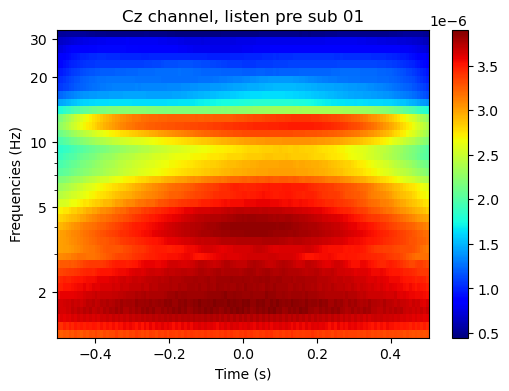

In [ ]:
channel = ['Cz']
#ch_idx = ch_index(channel)
ch_idx = 0 #working on arrays with only one channel index


test_wavelet = np.squeeze(wavelet_transform_mean[ch_idx,:,:])
plot_scaleogram(test_wavelet, freqs, times) 
plt.title(f'{channel[0]} channel, {task} {period} sub {sub}')

#### Plot topomap for a frequency band

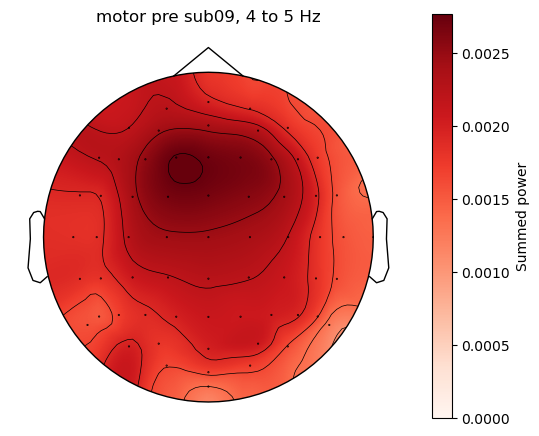

In [ ]:
freq_band = [4,5] #10-15 for beta, 4-5 for listening-related ERP
power_ch = sum_over_channels(wavelet_transform_mean, freq_band, freqs)

fig, ax = plt.subplots()
ax.set_title(f'{task} {period} sub{sub}, {freq_band[0]} to {freq_band[1]} Hz')

cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Summed power')

#plot this last
pos = load_ep_info()
im, _=mne.viz.plot_topomap(power_ch, pos, axes = ax)



In [62]:
wavelet_trans_info = loadmat('wavelet/wavelets_mat_listen__n05to05_30Hz_Cz/wavelet_record.mat')


FileNotFoundError: [Errno 2] No such file or directory: 'wavelet/wavelets_mat_listen__n05to05_30Hz_Cz/wavelet_record.mat'

### Load data for multiple subjects

In [126]:
def power_over_subs(subjects_to_process, wavelet_dir, freqs_to_sum):

    """ 
    NOTES: Currently assumes that all data contains only one channel

    Averages the wavelets over trials before processing

    Sums the power over time for multiple subjects
    freqs_to_sum: Range of freqs to sum over from low to high bound, or 'all'
        if 'all', the dataframe will return power as arrays of size freqs x power
    
    ---
    returns: dataframe with colums for subjects, periods, musicianship, and summed power at each frequency
    """
    #task = wavelet_dir.split("/")[-1].split('_')[2]

    info_path = os.path.join(wavelet_dir, "wavelet_record.mat")
    wavelet_trans_info = loadmat(info_path)
    freqs = wavelet_trans_info['freqs'][0]

    power_df = pd.DataFrame(columns=['subject', 'musician', 'period', 'power'])
    _, _, musicians, _ = load_subject_lists()

    for wavelet_file in sorted(os.listdir(wavelet_dir)):
        sub_id = wavelet_file.split(".")[0].split('_')[-1]
        period =  wavelet_file.split(".")[0].split('_')[-2]

        if sub_id not in subjects_to_process:
            # print(f'skipping sub {sub_id}')
            continue
        
        #print('proccessing', wavelet_file)
        data = loadmat(os.path.join(wavelet_dir, wavelet_file))
        wavelet_sub = data['wavelet_transform']
        wavelet_sub_ave = np.mean(wavelet_sub, axis = 0).squeeze()

        #take subset that is relevant for the frequency
        if isinstance(freqs_to_sum, str) and freqs_to_sum == 'all':
            power_arr = np.zeros(wavelet_sub_ave.shape[0])
            for i, freq in enumerate(freqs): 
                
                power = sum_wavelet_power(wavelet_sub_ave, [freq], freqs)
                power_arr[i] = power
        else:
            power_arr = sum_wavelet_power(wavelet_sub_ave, freqs_to_sum, freqs)
            
        
        #add to dataframe
        power_df_sub = pd.DataFrame({
            'subject': sub_id,
            'period': period,
            'power': [power_arr]

        })
        if sub_id in musicians:
            power_df_sub['musician'] = 1
        else: 
            power_df_sub['musician'] = 0
        power_df = pd.concat([power_df, power_df_sub])

    return power_df
            


In [ ]:

wavelet_dir = '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/wavelet/wavelets_mat_listen__n05to05_30Hz_Cz'
power_df_all = power_over_subs(subjects_to_process, wavelet_dir, freqs_to_sum='all')

In [206]:
def plot_power_freqs(freqs, power_data, label = None, color = None):

    if isinstance (power_data, pd.DataFrame):
    # Assuming power_df_all['power'] is a 2D array where rows are observations (e.g., trials or subjects) and columns are frequencies
        power = np.array(power_data['power'].tolist())  # Convert to numpy array if it's not already
    else: 
        assert isinstance(power_data, np.ndarray)
        power = power_data
    power_mean = power.mean(axis=0)  # Mean across observations
    power_sem = power.std(axis=0, ddof=1) / np.sqrt(power.shape[0])  # SEM computation

    # Plot the mean power spectrum
    plt.plot(freqs, power_mean, label = label, color = color)

    # Add SEM as a shaded region
    plt.fill_between(freqs, 
                    power_mean - power_sem, 
                    power_mean + power_sem, 
                    color = color,
                    alpha=0.3)
    plt.xscale('log')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power')
    plt.legend()

In [172]:
power_musicians_pre = power_df_all.query("musician == 1 & period == 'pre'")
power_musicians_post = power_df_all.query("musician == 1 & period == 'post'")
power_nonmusicians_pre = power_df_all.query("musician == 0 & period == 'pre'")
power_nonmusicians_post = power_df_all.query("musician == 0 & period == 'post'")


#power_diff = power_musicians_post-power_musicians_pre

Text(0.5, 1.0, 'Musicians')

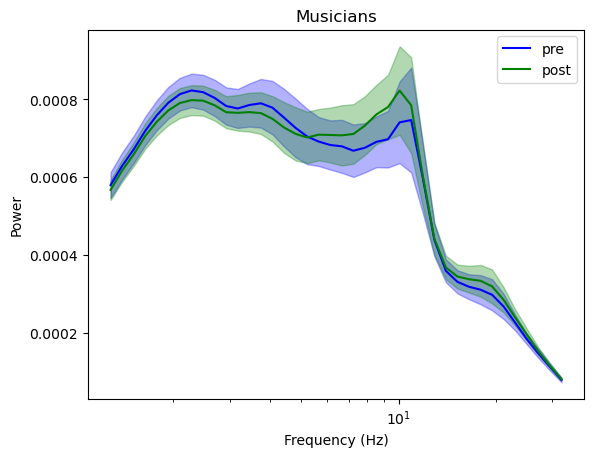

In [207]:
plot_power_freqs(freqs, power_musicians_pre, color = 'blue', label = 'pre')
plot_power_freqs(freqs, power_musicians_post, color = 'green', label = 'post')
plt.title('Musicians')

In [222]:
power_diff = power_musicians_post['power']-power_musicians_pre['power']
power_diff = np.vstack(power_diff)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'listen difference post-pre, nonmusicians')

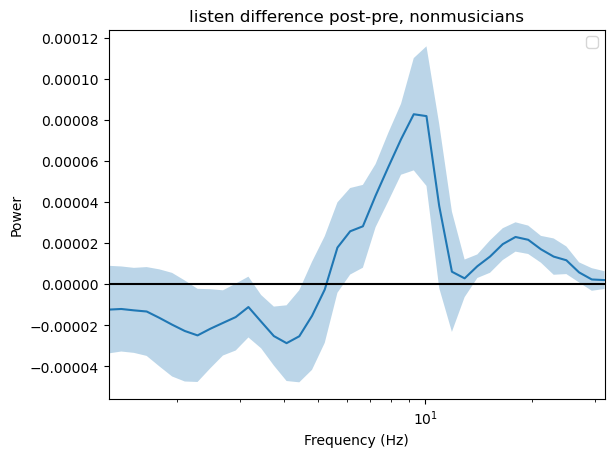

In [223]:
plot_power_freqs(freqs,power_diff)
plt.hlines(0,freqs[-1], freqs[0], color = 'black')
plt.xlim(freqs[-1], freqs[0])
plt.title(f'{task} difference post-pre, nonmusicians')